In [1]:
import sys
import os
from pathlib import Path

pwd  = Path(os.getcwd())
sys.path.append(str(pwd.parent.parent)) # needed to use "koray" module

In [2]:
import pandas as pd
import numpy as np

In [3]:
from koray.feature_calculation.util import get_features

conference_invitations = [
# 'NeurIPS.cc/2022/Conference/-/Blind_Submission',
'ICLR.cc/2023/Conference/-/Blind_Submission',
# 'ICLR.cc/2022/Conference/-/Blind_Submission',
# 'ICLR.cc/2021/Conference/-/Blind_Submission',
]

# feature_df = list(get_features(conference_invitations, disable_cache=True))
feature_df = list(get_features(conference_invitations, disable_cache=False))
df = pd.concat(feature_df)
df


✔ Successfully calculated features


,paper_id,abstract_length,author_count,is_accepted,keyword_count,metareview_length,reviewer_confidence_nanmax,reviewer_confidence_nanmean,reviewer_confidence_nanmedian,reviewer_confidence_nanmin,...,reviewer_recommendation_nanstd,reviewer_recommendation_nanvar,reviewer_technical_novelty_and_significance_nanmax,reviewer_technical_novelty_and_significance_nanmean,reviewer_technical_novelty_and_significance_nanmedian,reviewer_technical_novelty_and_significance_nanmin,reviewer_technical_novelty_and_significance_nanstd,reviewer_technical_novelty_and_significance_nanvar,title_length,tldr_length
0,-0tPmzgXS5,1197.0,5.0,False,3.0,NaN,4.0,4.000000,4.0,4.0,...,0.471405,0.222222,3.0,2.666667,3.0,2.0,0.471405,0.222222,46.0,131.0
1,-1x2-lp1eZf,1862.0,7.0,False,3.0,NaN,5.0,4.200000,4.0,4.0,...,1.200000,1.440000,3.0,2.400000,2.0,2.0,0.489898,0.240000,74.0,114.0
2,-2zfgNS917,1497.0,6.0,True,3.0,NaN,4.0,3.500000,3.5,3.0,...,0.866025,0.750000,3.0,2.250000,2.0,2.0,0.433013,0.187500,75.0,97.0
3,-4DiyBMgv9m,1246.0,2.0,False,0.0,NaN,4.0,3.000000,3.0,2.0,...,1.939072,3.760000,3.0,2.800000,3.0,2.0,0.400000,0.160000,89.0,0.0
4,-4Maz7s3YXz,1366.0,2.0,False,5.0,NaN,4.0,4.000000,4.0,4.0,...,0.942809,0.888889,3.0,2.666667,3.0,2.0,0.471405,0.222222,65.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,zufPou5foW,1393.0,5.0,False,4.0,NaN,4.0,3.750000,4.0,3.0,...,1.299038,1.687500,2.0,2.000000,2.0,2.0,0.000000,0.000000,82.0,0.0
3792,zyLVMgsZ0U_,1107.0,6.0,True,6.0,NaN,4.0,3.250000,3.0,3.0,...,0.000000,0.000000,4.0,3.500000,3.5,3.0,0.500000,0.250000,100.0,205.0
3793,zyfEWkV6it,1157.0,5.0,False,3.0,NaN,5.0,4.000000,4.5,2.0,...,1.247219,1.555556,3.0,2.166667,2.0,1.0,0.687184,0.472222,45.0,0.0
3794,zzL_5WoI3I,965.0,2.0,False,3.0,NaN,4.0,3.666667,4.0,3.0,...,2.054805,4.222222,4.0,3.000000,3.0,2.0,0.816497,0.666667,83.0,208.0


In [4]:
# columns that have numerical values
numerical_columns = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]

/Users/koray/data-literacy-group16/koray/.venv/lib/python3.13/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


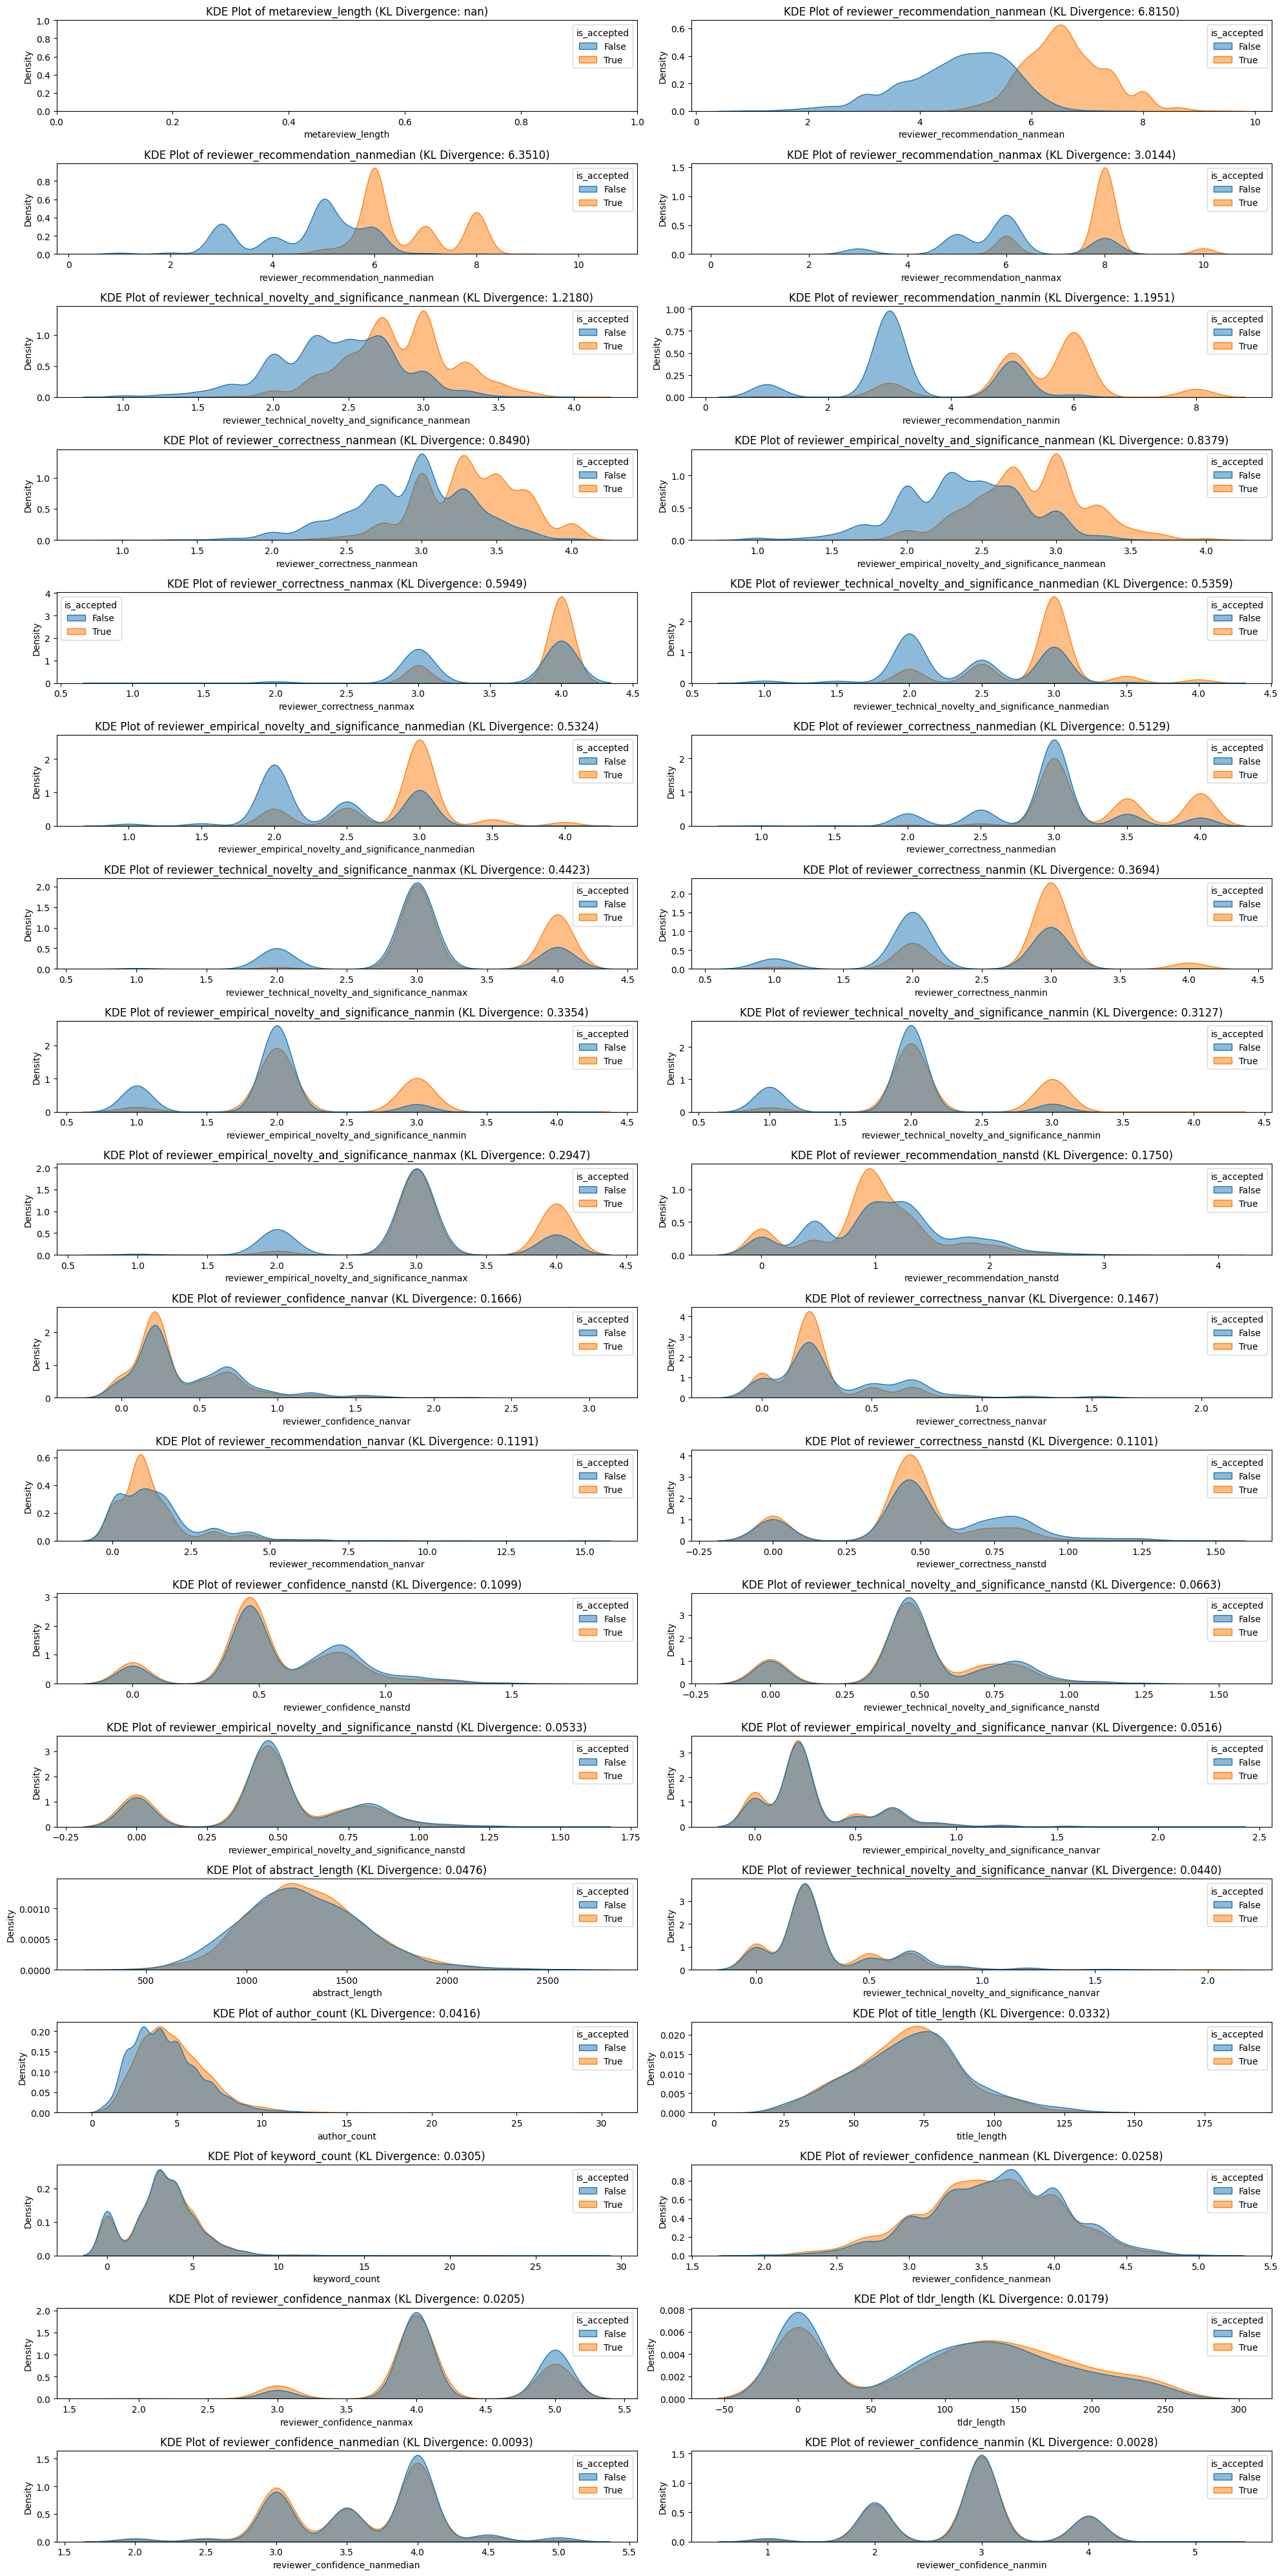

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Calculate KL divergence
def calculate_kl_divergence(df, column, group_col='is_accepted'):
    group_0 = df[df[group_col] == 0][column].dropna()
    group_1 = df[df[group_col] == 1][column].dropna()
    
    # Calculate histograms for each group
    p, bins = np.histogram(group_0, bins=30, density=True)
    q, _ = np.histogram(group_1, bins=bins, density=True)
    
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    
    # Normalize to ensure they are probabilities
    p = p / p.sum()
    q = q / q.sum()
    
    # Calculate KL divergence
    return entropy(p, q)

# Compute KL divergence for all numerical columns
kl_divergences = {
    col: calculate_kl_divergence(df, col, group_col='is_accepted')
    for col in numerical_columns
}

# Sort numerical columns by KL divergence in descending order
sorted_columns = sorted(kl_divergences, key=kl_divergences.get, reverse=True)

plt.figure(figsize=(20, 40))


for i, col in enumerate(sorted_columns, 1):
    plt.subplot(len(sorted_columns) // 2, 2, i)
    sns.kdeplot(data=df, x=col, hue='is_accepted', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'KDE Plot of {col} (KL Divergence: {kl_divergences[col]:.4f})')

plt.tight_layout()
plt.show()


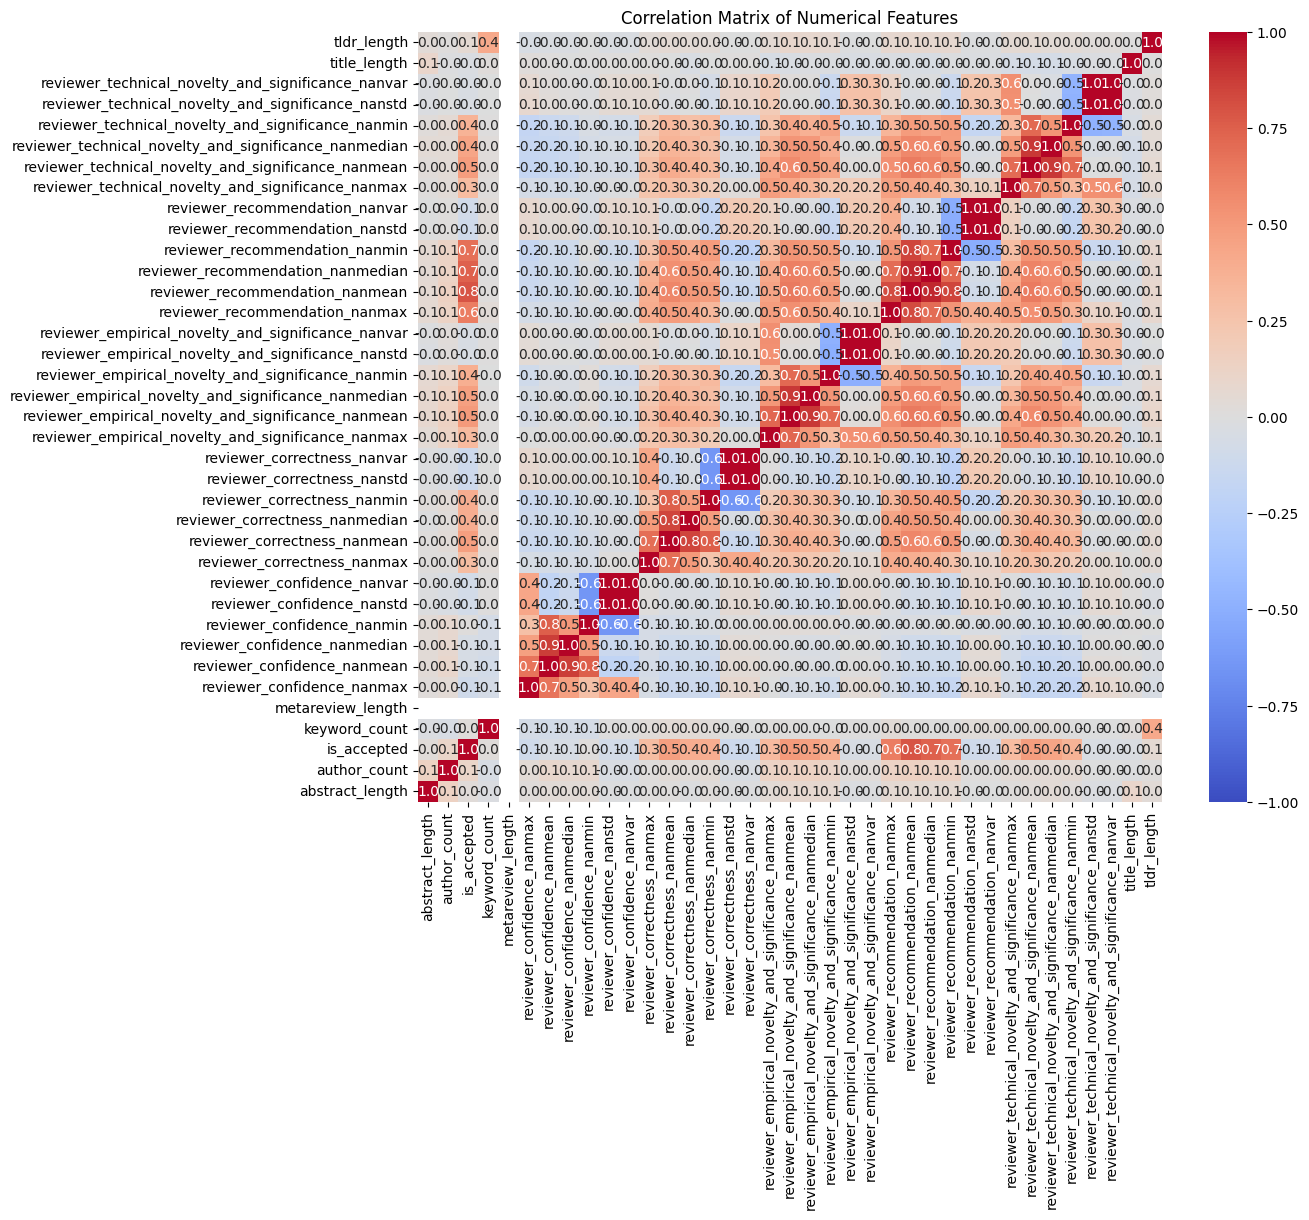

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pointbiserialr


# correlation_matrix = df.corr(numeric_only=True, method='pearson')
correlation_matrix = df.corr(numeric_only=True, method='spearman')
# correlation_matrix = df.corr(numeric_only=True, method=lambda x,y : pointbiserialr(x,y)[0])


# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(correlation_matrix, annot=True, fmt='.01f', cmap='coolwarm', cbar=True,  vmin=-1, vmax=1)

# Flip the y-axis
ax.invert_yaxis()

plt.title("Correlation Matrix of Numerical Features")
plt.show()

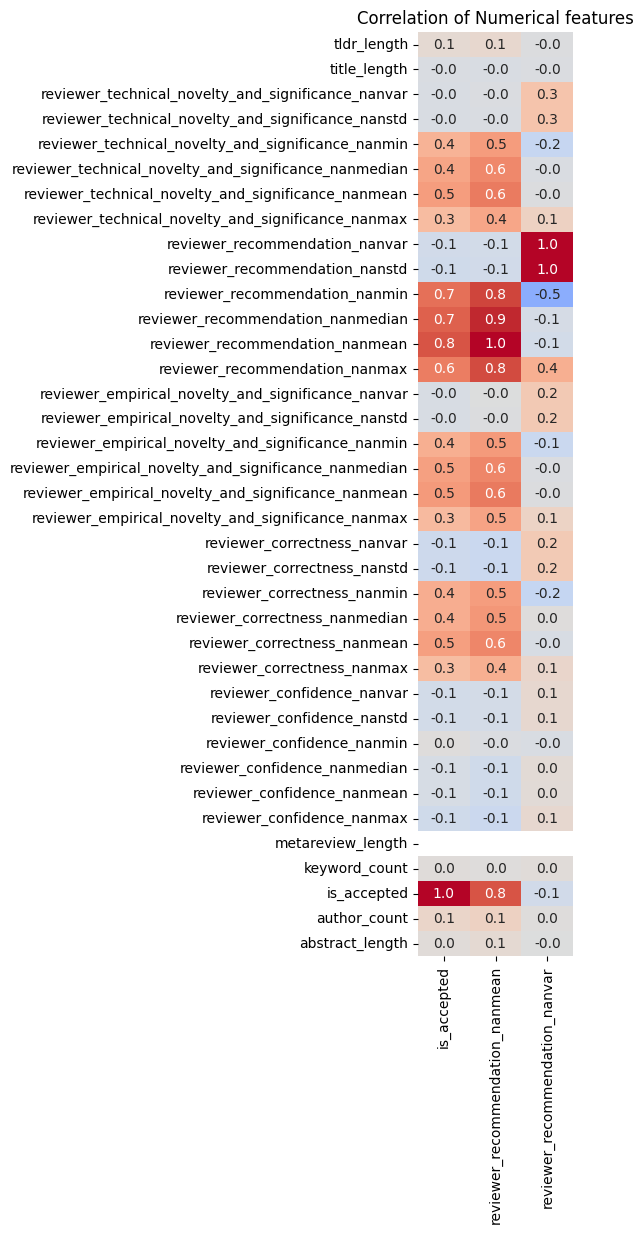

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_subset = correlation_matrix.loc[:, [
    'is_accepted',
    'reviewer_recommendation_nanmean',
    'reviewer_recommendation_nanvar',
]]

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(2, 12))  # Adjust the figure size for better visibility
ax = sns.heatmap(correlation_subset, annot=True, fmt='.1f', cmap='coolwarm', cbar=False, center=0, vmin=-1, vmax=1)

# Flip the y-axis to have reviewer_confidence_nanvar at the top
ax.invert_yaxis()

plt.title("Correlation of Numerical features")
plt.show()